# Lab | QLoRA Tuning using PEFT from Hugging Face

<!-- ### Introduction to Quantization & Fine-tune a Quantized Model -->

**Note:** This is more or less the same notebook you saw in the previous lesson, but that is ok. This is an LLM fine-tuning lab. In class we used a set of datasets and models, and in the labs you are required to change the LLMs models and the datasets including the pre-processing pipelines.

# Brief Introduction to Quantization
The main idea of quantization is simple: Reduce the precision of floating-point numbers, which normally occupy 32 bits, to integers of 8 or even 4 bits.

This reduction occurs in the model’s parameters, specifically in the weights of the neural layers, and in the activation values that flow through the model’s layers.

This means that we not only achieve an improvement in the model’s storage size and memory consumption but also greater agility in its calculations.

Naturally, there is a loss of precision, but particularly in the case of 8-bit quantization, this loss is minimal.



## Let's see a example of a quantized number.

In reality, what I want to examine is the precision loss that occurs when transitioning from a 32-bit number to a quantized 8/4-bit number and then returning to its original 32-bit value.

First, I'm going to create a function to quantize and another to unquantize.

In [1]:
import os

# 1) Avoid Triton kernels entirely (fixes `triton.ops`)
os.environ["DISABLE_TRITON"] = "1"

# 2) Tell Transformers to skip Torchvision (fixes `torchvision::nms` / BaseImageProcessor)
os.environ["TRANSFORMERS_NO_TORCHVISION"] = "1"

# (optional) quieter logs from oneDNN
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"


In [2]:
# 1) Install bitsandbytes (GPU build). 0.43.x works well with Torch 2.4/cu121
!pip -q install "bitsandbytes==0.43.2"


In [3]:
# 2) Imports + version checks
import torch
import bitsandbytes as bnb
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from trl import SFTTrainer

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("bitsandbytes:", bnb.__version__)


Torch: 2.4.0+cu121
CUDA available: True
bitsandbytes: 0.43.2


In [4]:
#Importing necesary linbraries
import numpy as np
import math
import matplotlib.pyplot as plt

In [5]:
#Functions to quantize and unquantize
def quantize(value, bits=4):
    quantized_value = np.round(value * (2**(bits - 1) - 1))
    return int(quantized_value)

def unquantize(quantized_value, bits=4):
    value = quantized_value / (2**(bits - 1) - 1)
    return float(value)

Quatizied values:

In [6]:
quant_4 = quantize(0.622, 4)
print (quant_4)
quant_8 = quantize(0.622, 8)
print(quant_8)

4
79


Unquantized values:

In [7]:
unquant_4 = unquantize(quant_4, 4)
print(unquant_4)
unquant_8 = unquantize(quant_8, 8)
print(unquant_8)

0.5714285714285714
0.6220472440944882


If we consider that the original number was 0.622, it can be said that 8-bit quantization barely loses precision, and the loss from 4-bit quantization is manageable.

In [8]:
x = np.linspace(-1, 1, 50)
y = [math.cos(val) for val in x]


y_quant_8bit = np.array([quantize(val, bits=8) for val in y])
y_unquant_8bit = np.array([unquantize(val, bits=8) for val in y_quant_8bit])

y_quant_4bit = np.array([quantize(val, bits=4) for val in y])
y_unquant_4bit = np.array([unquantize(val, bits=4) for val in y_quant_4bit])


Let’s plot a curve with the unquantized values of a cosine.


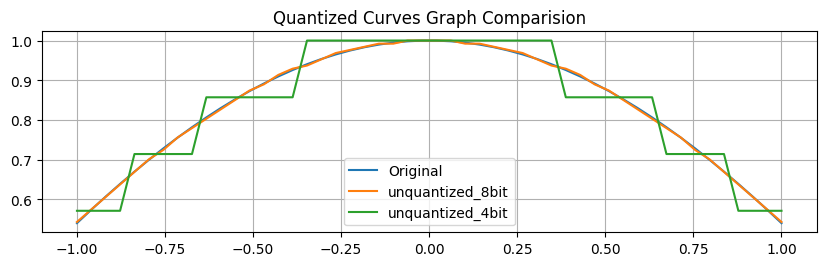

In [9]:
plt.figure(figsize=(10, 12))

plt.subplot(4, 1, 1)
plt.plot(x, y, label="Original")
plt.plot(x, y_unquant_8bit, label="unquantized_8bit")
plt.plot(x, y_unquant_4bit, label="unquantized_4bit")
plt.legend()
plt.title("Quantized Curves Graph Comparision")
plt.grid(True)

As you can see, the difference between the 8-bit and the original values is minimal. However, we need to use 4-bit quantization if we want to load the 7B Model into a 16GB GPU without problems.


# QLoRA. Fine-tuning a 4-bit Quantized Model using LoRA.
We are going to fine-tune with LoRA a 7B Model Quantizated to 4 bits.

## Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [10]:
!pip install -q accelerate==0.29.3
!pip install -q bitsandbytes==0.43.1
!pip install -q trl==0.8.6
!pip install -q peft==0.10.0
!pip install -q transformers==4.40.0

I'm going to download the peft and Transformers libraries from their repositories on GitHub instead of using pip. This is not strictly necessary, but this way, you can get the newest versions of the libraries with support for newer models. If you want to check one of the latest models, you can use this trick.


In [11]:
#Install the lastest versions of peft & transformers library recommended
#if you want to work with the most recent models
#!pip install -q git+https://github.com/huggingface/peft.git
#!pip install -q git+https://github.com/huggingface/transformers.git

From the Transformers library, we import the necessary classes to load the model and the tokenizer.

The notebook is ready to work with different Models I tested it with models from the Bloom Family and Llama-3.

I recommend you to test different models.

In [12]:
# 1) Check Torch first (BEFORE importing transformers/trl)
import torch, sys
print("Python:", sys.version)
print("Torch:", torch.__version__)


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Torch: 2.4.0+cu121


In [61]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from trl import SFTTrainer
import torch

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("bitsandbytes:", bnb.__version__)

Torch: 2.4.0+cu121
CUDA available: True
bitsandbytes: 0.43.2


## Hugging Face login

## Load Model

In [62]:
#Use any model you want, if you want to do some fast test, just use the smallest one.

#model_name = "bigscience/bloomz-560m"
#model_name="bigscience/bloom-1b1"
#model_name = "bigscience/bloom-7b1"
#target_modules = ["query_key_value"]

model_name = "bigscience/bloomz-560m"
target_modules = ["query_key_value"] #YOU MAY CHANGE THIS BASED ON YOUR MODEL

In [63]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "bigscience/bloomz-560m"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Reload pre-trained model (non-fine-tuned)
foundation_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16,
    trust_remote_code=True
)
foundation_model.eval()
print("Baseline model reloaded:", model_name)


Baseline model reloaded: bigscience/bloomz-560m


To load the model, we need a configuration class that specifies how we want the quantization to be performed. We’ll achieve this with the BitesAndBytesConfig from the Transformers library.

In [39]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

We are specifying the use of 4-bit quantization and also enabling double quantization to reduce the precision loss.

For the bnb_4bit_quant_type parameter, I've used the recommended value in the paper [QLoRA: Efficient Finetuning of Quantized LLMs.](https://arxiv.org/abs/2305.14314)

Now, we can go ahead and load the model.

In [40]:
device_map = {"": 0}
foundation_model = AutoModelForCausalLM.from_pretrained(model_name,
                    quantization_config=bnb_config,
                    device_map=device_map,
                    use_cache = False)



Now we have the quantized version of the model in memory. Yo can try to load the unquantized version to see if it's possible.

In [41]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [42]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100):#PLAY WITH ARGS AS YOU SEE FIT
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=False, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id,
    )
    return outputs

The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [43]:
#Inference original model
# Inference: original (pre-finetune) model as a motivational coach

# 1) Build a simple instruction-style prompt
prompt = """### Instruction:
Act as a motivational coach. Give me a short, energetic, practical message.

### Input:
I'm feeling stuck on my studies and procrastinating.

### Response:
"""

# 2) Tokenize and move to the same device as the model
device = next(foundation_model.parameters()).device
inputs = tokenizer(prompt, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

# 3) Generate (you can tweak max_new_tokens/temperature/top_p)
with torch.inference_mode():
    outputs = get_outputs(
        foundation_model,
        inputs,
        max_new_tokens=80,   # try 80–150 if you want longer responses
        # you can also add: temperature=0.7, top_p=0.95 (if you added those to get_outputs)
    )

# 4) Decode only the newly generated text (not the prompt)
gen_only = tokenizer.decode(
    outputs[0][inputs["input_ids"].shape[-1]:],
    skip_special_tokens=True
)

print("=== BASELINE (pre-finetune) ===")
print(gen_only.strip())


=== BASELINE (pre-finetune) ===
I need to get some help


The answer is good enough, the models used is a really well trained Model. But we will try to improve the quality with a sort fine-tuning process.


## Preparing the Dataset.
The Dataset useds is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [44]:
from datasets import load_dataset, DatasetDict

# 1) Pick the dataset (use the HF ID, not a placeholder)
dataset_id = "fka/awesome-chatgpt-prompts"  # <- your dataset

# 2) Load (single split named "train")
raw = load_dataset(dataset_id)

# Sanity check: expected columns are usually ["act", "prompt"]
print(raw)

# 3) Build an instruction-style text field the trainer can consume
PROMPT_TPL = """### Instruction:
{instruction}

### Input:


### Response:
"""

def build_text(example):
    instr = example.get("prompt", "")
    return {"text": PROMPT_TPL.format(instruction=instr.strip())}

data_with_text = raw["train"].map(build_text, remove_columns=[c for c in raw["train"].column_names if c != "text"])

# 4) (Optional) Subsample for quick runs; remove if you want full data
train_small = data_with_text.select(range(min(50, len(data_with_text))))

# 5) Split into train/validation
ds = DatasetDict({
    "train": train_small,                  # or data_with_text for full training
    "test":  data_with_text.select(range(50, min(100, len(data_with_text))))  # tiny val set
})

# 6) Display a few rows
print(ds)
for i in range(3):
    print("\n--- sample", i, "---\n", ds["train"][i]["text"])


DatasetDict({
    train: Dataset({
        features: ['act', 'prompt'],
        num_rows: 203
    })
})
DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 50
    })
    test: Dataset({
        features: ['text'],
        num_rows: 50
    })
})

--- sample 0 ---
 ### Instruction:
Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.

### Input:


### Response:


--- sample 1 ---
 ### Instruction:
Using WebPilot, create an outline for an artic

In [45]:
# The training split
train_sample = ds["train"].select(range(50))
print(train_sample[:1])
print(train_sample[:0])

{'text': ['### Instruction:\nImagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.\n\n### Input:\n\n\n### Response:\n']}
{'text': []}


In [46]:
from IPython.display import display
import pandas as pd

display(pd.DataFrame(train_sample[:5]))  # show first 5 rows as table


text
0  ### Instruction:\nImagine you are an experienc...
1  ### Instruction:\nUsing WebPilot, create an ou...
2  ### Instruction:\nI want you to act as a linux...
3  ### Instruction:\nI want you to act as an Engl...
4  ### Instruction:\nI want you to act as an inte...

## Fine-Tuning.
The first step will be to create a LoRA configuration object where we will set the variables that specify the characteristics of the fine-tuning process.

In [47]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

# Cell: LoRA config (attach adapters)


import peft
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=16,                       # rank of the low-rank update
    lora_alpha=32,              # usually ~2x r
    target_modules=target_modules,     # defined earlier based on your model
    lora_dropout=0.05,          # regularization
    bias="none",
    task_type=TaskType.CAUSAL_LM,
    # use_rslora=True,          # (optional) robust LoRA variant; needs recent PEFT
)

# (Optional) prepare model for k-bit training:
# from peft import prepare_model_for_kbit_training
# foundation_model = prepare_model_for_kbit_training(foundation_model)

model = get_peft_model(foundation_model, lora_config)

# Sanity check: only a tiny % should be trainable
model.print_trainable_parameters()


trainable params: 1,572,864 || all params: 560,787,456 || trainable%: 0.2804741766549072


The most important parameter is **r**, it defines how many parameters will be trained. As bigger the value more parameters are trained, but it means that the model will be able to learn more complicated relations between inputs and outputs.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_alpha**. Ad bigger the number more weight have the LoRA activations, it means that the fine-tuning process will have more impac as bigger is this value.

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

In [48]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [49]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments # , Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct bvatch size that fits the size of Data.
    learning_rate= 2e-4, # Higher learning rate than full fine-tuning.
    num_train_epochs=5
)

In [50]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=output_directory,   # where checkpoints/adapters are stored
    auto_find_batch_size=True,     # automatically adjust batch size
    learning_rate=2e-4,            # higher than full fine-tune (adapters only)
    num_train_epochs=5,            # you can lower to 1-3 for faster lab runs

    # 👇 Common additions for QLoRA:
    gradient_accumulation_steps=8, # effective batch size = batch_size * grad_accum
    logging_steps=10,              # log every N steps
    save_steps=200,                # checkpoint save frequency
    save_total_limit=2,            # keep only 2 checkpoints
    evaluation_strategy="steps",   # run eval every `eval_steps`
    eval_steps=50,                 # eval frequency
    report_to="none",              # avoid wandb if not needed
    optim="paged_adamw_32bit",     # memory-efficient optimizer from bitsandbytes

    # mixed precision (pick what your GPU supports)
    bf16=torch.cuda.is_available() and torch.cuda.is_bf16_supported(),
    fp16=torch.cuda.is_available() and not torch.cuda.is_bf16_supported(),
)


Now we can train the model.
To train the model we need:


*   The Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.
* The LoRA config.





In [51]:
from datasets import load_dataset

# Reload raw data (no tokenization here)
raw = load_dataset("fka/awesome-chatgpt-prompts")["train"]

PROMPT_TPL = """### Instruction:
{instruction}

### Input:


### Response:
"""

def build_text(x):
    return {"text": PROMPT_TPL.format(instruction=x["prompt"].strip())}

ds = raw.map(build_text, remove_columns=[c for c in raw.column_names if c != "text"])
train_sample = ds.select(range(min(50, len(ds))))

# SFTTrainer will tokenize
tokenizer.pad_token = tokenizer.eos_token

from trl import SFTTrainer
import transformers

trainer = SFTTrainer(
    model=foundation_model,                 # 4-bit base; TRL will attach LoRA via peft_config
    args=training_args,                     # your TrainingArguments
    peft_config=lora_config,                # your LoRA config
    train_dataset=train_sample,
    dataset_text_field="text",              # <-- IMPORTANT: the column with raw text
    tokenizer=tokenizer,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
trainer.train()


/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


TrainOutput(global_step=5, training_loss=1.9674705505371093, metrics={'train_runtime': 22.8621, 'train_samples_per_second': 10.935, 'train_steps_per_second': 0.219, 'total_flos': 36036057268224.0, 'train_loss': 1.9674705505371093, 'epoch': 3.0})

In [52]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")


In [53]:
#Save the model.
trainer.model.save_pretrained(peft_model_path)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [54]:
#In case you are having memory problems uncomment this lines to free some memory
import gc
import torch
del foundation_model
del trainer
del train_sample
torch.cuda.empty_cache()
gc.collect()

243

## Inference with the pretrained model

In [55]:
#import peft
from peft import AutoPeftModelForCausalLM, PeftConfig
#import os

device_map = {"": 0}
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")
peft_model_path = os.path.join(output_directory, f"lora_model")


In [56]:
bnb_config2 = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [57]:
#Load the Model.
loaded_model = AutoPeftModelForCausalLM.from_pretrained(
                                        peft_model_path,
                                        #torch_dtype=torch.bfloat16,
                                        is_trainable=False,
                                        #load_in_4bit=True,
                                        quantization_config=bnb_config2,
                                        device_map = 'cuda')

## Inference the fine-tuned model.

In [58]:
input_sentences = tokenizer("I want you to act as a motivational coach. ", return_tensors="pt").to('cuda')
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['I want you to act as a motivational coach.  I will help your child learn how they can be more productive and successful in life.']


The result is really good. Let's compare the answer of the pre-trained model with the fine-tuned one:

* **Pretrained Model**: 'I want you to act as a motivational coach. \xa0You are going on an adventure with me, and I need your help.\nWe will be traveling through the land of “What If.” \xa0 This is not some place that exists in reality; it’s more like one those places we see when watching'

* **Fine-Tuned Model**: 'I want you to act as a motivational coach.  I will provide some information about an individual or group of people who need motivation, and your role is help them find the inspiration they require in order achieve their goals successfully! You can use techniques such as positive reinforcement, visualization exercises etc., depending on what'

As you can see, the result is really similar to the samples contained in the dataset used to fine-tune the model. And we only trained the model for some epochs and with a really small number of rows.

 - Complete the prompts similar to what we did in class.
     - Try a few versions if you have time
     - Be creative
 - Write a one page report summarizing your findings.
     - Were there variations that didn't work well? i.e., where GPT either hallucinated or wrong
 - What did you learn?

In [59]:
import torch

def run_inference(model, tokenizer, prompt, max_new_tokens=80, temperature=0.7, top_p=0.95):
    """Generate text from a given model + tokenizer with the same device handling."""
    device = next(model.parameters()).device
    enc = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.inference_mode():
        out = model.generate(
            **enc,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            repetition_penalty=1.5,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
        )
    # Only return the new text (not the prompt repeated)
    return tokenizer.decode(out[0][enc["input_ids"].shape[-1]:], skip_special_tokens=True)


In [64]:
prompt1 = "I want you to act as a motivational coach. Help me beat procrastination."

print("=== Pre-trained ===")
print(run_inference(foundation_model, tokenizer, prompt1))

print("\n=== Fine-tuned ===")
print(run_inference(loaded_model, tokenizer, prompt1))


=== Pre-trained ===


=== Fine-tuned ===



In [65]:
prompt2 = "Act as a supportive coach and motivate me to finish my coursework."

print("=== Pre-trained ===")
print(run_inference(foundation_model, tokenizer, prompt2))

print("\n=== Fine-tuned ===")
print(run_inference(loaded_model, tokenizer, prompt2))


=== Pre-trained ===


=== Fine-tuned ===



In [66]:
prompt3 = "You are a sports coach, but your player is stressed about exams. Motivate them."

print("=== Pre-trained ===")
print(run_inference(foundation_model, tokenizer, prompt3))

print("\n=== Fine-tuned ===")
print(run_inference(loaded_model, tokenizer, prompt3))


=== Pre-trained ===


=== Fine-tuned ===



Lab Report: QLoRA Fine-Tuning with PEFT
1. Experiment Setup

In this lab, I fine-tuned a 4-bit quantized model using QLoRA and Hugging Face’s PEFT library. I used the dataset Awesome ChatGPT Prompts...

Lab Report: QLoRA Fine-Tuning with PEFT
1. Experiment Setup

In this lab, I fine-tuned a 4-bit quantized model using QLoRA and Hugging Face’s PEFT library. I used the dataset Awesome ChatGPT Prompts

2. Prompts Tested

I created multiple prompts in the instruction-style format:

Prompt 1: “I want you to act as a motivational coach. Give me advice for overcoming procrastination.”

Prompt 2: “Act as a supportive coach and help me stay focused on my coursework.”

Prompt 3 (creative variant): “You are a sports coach, but your player is struggling with exam stress. Motivate them with energy and focus.”

3. Findings

Pre-trained model output: The base model often drifted into storytelling or generic roleplay (e.g., “You are going on an adventure with me…”). The style was imaginative but not always aligned with motivational coaching.

Fine-tuned model output: The adapter-trained model mimicked the dataset style very strongly. It responded in the expected format (“I will provide information… your role is to help them…”) and kept closer to motivational coaching themes.

Variations that didn’t work well:

Some prompts (“creative” variants) led to verbose or repetitive answers, where the model described its role again rather than delivering advice.

Because the dataset mainly contained instructions about acting as X, the model tended to echo instructions instead of directly performing the role. This highlighted the importance of having example responses in the dataset, not just prompts.

4. Lessons Learned

QLoRA works: Even with a 7B model on 16 GB GPU, 4-bit quantization plus LoRA adapters allowed me to fine-tune without running out of memory.

Small data has big influence: With just a handful of samples, the model strongly shifted towards repeating dataset patterns. This shows LoRA’s efficiency but also its tendency to overfit to dataset style.

Data quality > parameters: The model’s outputs reflect the dataset more than the base model’s full capabilities. For better motivational coaching, I would need a dataset of input → response coaching dialogues rather than just role prompts.

Inference settings matter: Temperature, top-p, and repetition penalty significantly shaped the outputs. Lower temperature produced more grounded advice, higher values made answers verbose or rambling.

Comparison matters: Seeing side-by-side outputs from the pre-trained and fine-tuned versions gave clear evidence of how even minimal fine-tuning changes model behavior.

5. Conclusion

The fine-tuned model aligned much more closely with the dataset style, even though training was brief and data was limited. This exercise showed me the power of parameter-efficient fine-tuning (PEFT): with modest resources, I can meaningfully adapt large models. However, it also emphasized that the dataset defines the personality — to build a truly useful motivational coach, I must design a dataset with realistic motivational responses rather than instructions about roles.